In [6]:
import pickle
import pandas as pd 


### Read measurements data from two consecutive days 

In [7]:
# sample data based on which the visualisations are created
day1 = pd.read_pickle(r'./measurements_sample_data/oneday.pickle')
day2 = pd.read_pickle(r'./measurements_sample_data/oneday2.pickle')


In [8]:
# 1 hour, in each hour data from sensors 
# each tuple data: (pm1, pm10, pm25, longitude, latitude)
day1[0]


print(f"Count of sensors measuring air quality: {len(day1[0])}")

Count of sensors measuring air quality: 48


### Merge data from pickles to DataFrame

In [9]:
from datetime import datetime, timedelta

time = datetime(2022, 12, 20)
air_df = pd.DataFrame(columns =['PM1', 'PM10', 'PM25', 'latitude', 'longitude'])

for day in [day1, day2]:
    for hour_data in day:
        new_df = pd.DataFrame(hour_data, columns =['PM1', 'PM10', 'PM25', 'latitude', 'longitude'])
        new_df['timestamp'] = time
        time = time + timedelta(hours=1)
        air_df = pd.concat([air_df, new_df])

In [10]:
air_df

,PM1,PM10,PM25,latitude,longitude,timestamp
0,15.40,30.75,23.06,19.940984,50.062006,2022-12-20 00:00:00
1,15.30,38.80,24.29,19.942561,50.064539,2022-12-20 00:00:00
2,17.21,47.44,32.20,19.933919,50.059085,2022-12-20 00:00:00
3,15.68,40.76,28.61,19.946008,50.057447,2022-12-20 00:00:00
4,11.76,26.28,20.28,19.928368,50.062418,2022-12-20 00:00:00
...,...,...,...,...,...,...
43,20.87,34.98,50.06,19.953954,50.099239,2022-12-21 23:00:00
44,17.24,31.08,45.15,20.001157,50.065971,2022-12-21 23:00:00
45,15.93,27.25,37.69,19.905241,50.094220,2022-12-21 23:00:00
46,18.40,32.55,49.42,20.002049,50.054622,2022-12-21 23:00:00


### Create air pollution change visualisation with Folium

In [215]:
pm1_data = []
for time in air_df['timestamp'].unique():
    temp=[]
    for index, record in air_df[air_df['timestamp'] == time].iterrows():
        temp.append([record['longitude'],record['latitude'], record['PM1']])
    pm1_data.append(temp)

In [216]:
# 1 hour perpared data
pm1_data[0]

[[50.062006, 19.940984, 15.4],
 [50.064539, 19.942561, 15.3],
 [50.059085, 19.933919, 17.21],
 [50.057447, 19.946008, 15.68],
 [50.062418, 19.928368, 11.76],
 [50.070088, 19.943812, 14.02],
 [50.057678, 19.926189, 13.91],
 [50.059685, 19.957563, 14.9],
 [50.063904, 19.922548, 14.62],
 [50.054907, 19.956501, 15.19],
 [50.049168, 19.946672, 0.0],
 [50.066747, 19.962083, 0.0],
 [50.064567, 19.918564, 13.63],
 [50.07174, 19.962317, 13.71],
 [50.057242, 19.914874, 13.65],
 [50.079672, 19.94919, 13.43],
 [50.044424, 19.952205, 14.74],
 [50.042557, 19.940229, 14.99],
 [50.047736, 19.919646, 13.22],
 [50.072968, 19.914829, 13.97],
 [50.072763, 19.911081, 11.92],
 [50.08017, 19.918918, 14.07],
 [50.038499, 19.94685, 0.0],
 [50.043741, 19.966589, 0.0],
 [50.067312, 19.90336, 13.47],
 [50.039816, 19.965351, 14.42],
 [50.057537, 19.897547, 14.18],
 [50.084134, 19.968416, 15.94],
 [50.091628, 19.941265, 15.48],
 [50.072281, 19.895887, 0.0],
 [50.071128, 19.892226, 19.32],
 [50.07413, 19.989012, 13.

In [217]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [218]:
air_df['timestamp'].apply(lambda timestamp: str(timestamp)).unique().tolist()[:5]

['2022-12-20 00:00:00',
 '2022-12-20 01:00:00',
 '2022-12-20 02:00:00',
 '2022-12-20 03:00:00',
 '2022-12-20 04:00:00']

## Create map

In [235]:
# create normal map
krakow_coords = [50.0496863, 19.944544]
map_krakow= folium.Map(krakow_coords, zoom_start=13)

### Get all PM1 sensors data (from 1 hour)

In [236]:
# get the data in order to create scale of colours in the heatmap
import numpy as np
arr = np.array(pm1_data)
data = [x[2] for x in arr[0]]
print(len(data))
# pm1_data[0]
print(data[:10])

48
[15.4, 15.3, 17.21, 15.68, 11.76, 14.02, 13.91, 14.9, 14.62, 15.19]


### Prepare heatmap legend (scale [0, max(data)])

In [237]:
# https://stackoverflow.com/questions/47163728/how-to-add-legend-gradient-in-folium-heat-map
# https://stackoverflow.com/questions/43322435/how-to-specify-gradient-parameter-to-folium-heatmap
import branca.colormap
from collections import defaultdict
import folium
import webbrowser
from folium.plugins import HeatMap 

steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, np.max(data1)).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(map_krakow) #add color bar at the top of the map
colormap

### Prepare gradient for heatmap (scale [0, 1])

In [238]:
steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
heatmap_gradient = dict(gradient_map)

In [239]:
heatmap_gradient

{0.0: '#ffffcc',
 0.05: '#ffffcc',
 0.1: '#fff8ba',
 0.15000000000000002: '#ffe895',
 0.2: '#ffe895',
 0.25: '#ffe083',
 0.30000000000000004: '#fec560',
 0.35000000000000003: '#feb44e',
 0.4: '#feb44e',
 0.45: '#fea546',
 0.5: '#fe953f',
 0.55: '#fd8038',
 0.6000000000000001: '#fb4b29',
 0.65: '#fb4b29',
 0.7000000000000001: '#e61f1d',
 0.75: '#e61f1d',
 0.8: '#d7111f',
 0.8500000000000001: '#b40026',
 0.9: '#b40026',
 0.9500000000000001: '#800026'}

### Create heatmap

### TODO: find better coloristic for this map, `YlOrRd_09` doesn't look the best

In [240]:
# create heatmap
hm = plugins.HeatMapWithTime(
    pm1_data, 
    display_index=True,
    index=air_df['timestamp'].apply(lambda timestamp: str(timestamp)).unique().tolist(),
    auto_play=True,
    radius=30,
    use_local_extrema=True,
    gradient=heatmap_gradient
)
# add heatmap on map 
hm.add_to(map_krakow)


map_krakow

### Comparison to the default coloristic

In [234]:
map_krakow

In [17]:
map_krakow.save('pm1_vis01.html')

# Plots

In [18]:
import matplotlib.pyplot as plt

In [19]:
from datetime import datetime

air_df

,PM1,PM10,PM25,latitude,longitude,timestamp
0,15.40,30.75,23.06,19.940984,50.062006,2022-12-20 00:00:00
1,15.30,38.80,24.29,19.942561,50.064539,2022-12-20 00:00:00
2,17.21,47.44,32.20,19.933919,50.059085,2022-12-20 00:00:00
3,15.68,40.76,28.61,19.946008,50.057447,2022-12-20 00:00:00
4,11.76,26.28,20.28,19.928368,50.062418,2022-12-20 00:00:00
...,...,...,...,...,...,...
43,20.87,34.98,50.06,19.953954,50.099239,2022-12-21 23:00:00
44,17.24,31.08,45.15,20.001157,50.065971,2022-12-21 23:00:00
45,15.93,27.25,37.69,19.905241,50.094220,2022-12-21 23:00:00
46,18.40,32.55,49.42,20.002049,50.054622,2022-12-21 23:00:00


In [20]:
air_df['time'] = air_df.timestamp.apply(lambda date: date.strftime("%m/%d/%Y %H:%M"))

In [21]:
air_df

,PM1,PM10,PM25,latitude,longitude,timestamp,time
0,15.40,30.75,23.06,19.940984,50.062006,2022-12-20 00:00:00,12/20/2022 00:00
1,15.30,38.80,24.29,19.942561,50.064539,2022-12-20 00:00:00,12/20/2022 00:00
2,17.21,47.44,32.20,19.933919,50.059085,2022-12-20 00:00:00,12/20/2022 00:00
3,15.68,40.76,28.61,19.946008,50.057447,2022-12-20 00:00:00,12/20/2022 00:00
4,11.76,26.28,20.28,19.928368,50.062418,2022-12-20 00:00:00,12/20/2022 00:00
...,...,...,...,...,...,...,...
43,20.87,34.98,50.06,19.953954,50.099239,2022-12-21 23:00:00,12/21/2022 23:00
44,17.24,31.08,45.15,20.001157,50.065971,2022-12-21 23:00:00,12/21/2022 23:00
45,15.93,27.25,37.69,19.905241,50.094220,2022-12-21 23:00:00,12/21/2022 23:00
46,18.40,32.55,49.42,20.002049,50.054622,2022-12-21 23:00:00,12/21/2022 23:00


### Create plots for one particular sensor (user can choose time interval and  one of the sensors f for plotting the data)

In [22]:
sensor_X = 19.940984
sensor_Y = 50.062006

sensor_data = air_df[(air_df.latitude == sensor_X) & (air_df.longitude == sensor_Y)]

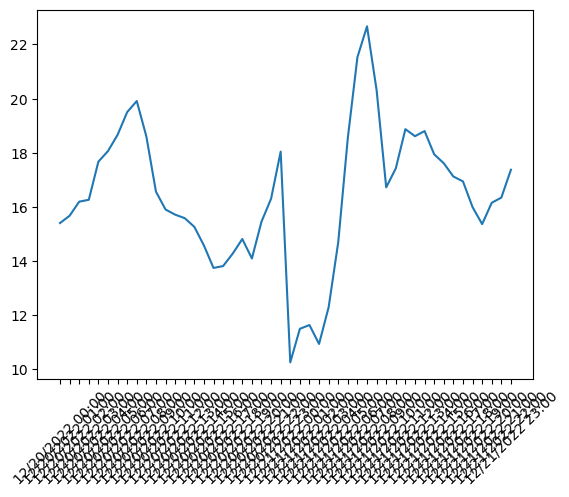

In [23]:
plt.xticks(rotation = 45) 
plt.plot(sensor_data['time'], sensor_data['PM1'])

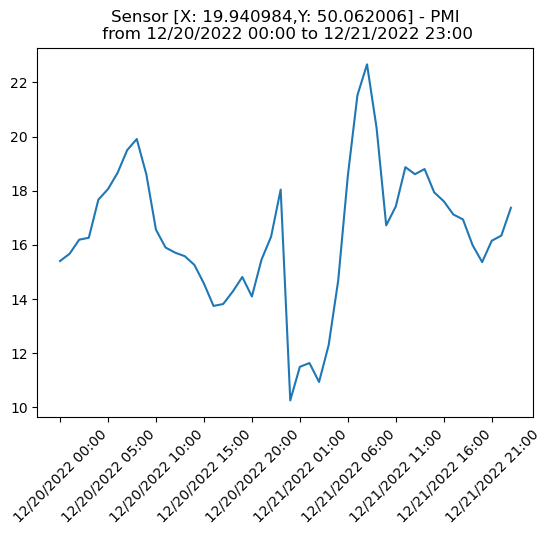

In [24]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,1)
plt.xticks(rotation = 45) 
tick_spacing = 5
ax.plot(sensor_data['time'], sensor_data['PM1'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_title(f'Sensor [X: {sensor_X},Y: {sensor_Y}] - PMI\n from {sensor_data.time.iloc[0]} to {sensor_data.time.iloc[-1]}')
fig.savefig('pm1_plot01.png')
plt.show()